In [5]:
#Plot 5 - Fraction of 

In [6]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [7]:
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [8]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [9]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [10]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50

################################
cesm2_path    = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
landfrac_path = '/global/scratch/users/harsha/LENS/cesm2/landfrac/'
cvals         = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals1        = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
##############################
print(cleft,cright)
print(euleft,euright)

235.21559209999998 293.0486188
350.0 50


In [11]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

In [12]:
cluster

In [13]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [14]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [15]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [16]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'},skipna=True)
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [17]:
cluster

In [18]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [19]:
%%time 
landfrac = xr.open_mfdataset(landfrac_path+'*.nc',engine='netcdf4')
landfrac = landfrac.LANDFRAC
landfrac

CPU times: user 843 ms, sys: 145 ms, total: 988 ms
Wall time: 988 ms


<xarray.DataArray 'LANDFRAC' (time: 192, lat: 192, lon: 288)>
dask.array<concatenate, shape=(192, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

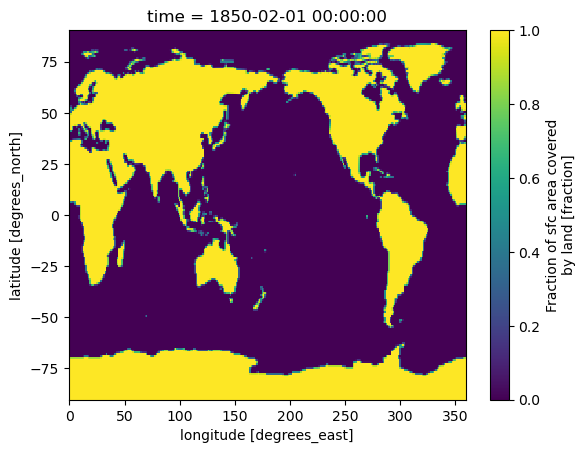

In [20]:
landfrac.sel(time='18500201').plot()

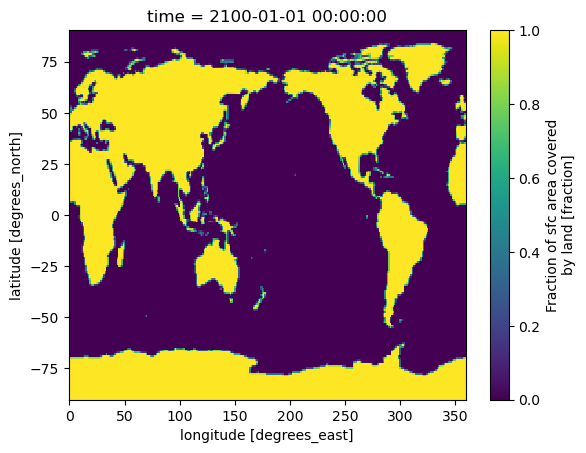

In [21]:
landfrac.sel(time='21000101').plot()

In [22]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 3.99 s, sys: 581 ms, total: 4.57 s
Wall time: 4.58 s


In [23]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
#tgnw

CPU times: user 591 ms, sys: 31.9 ms, total: 623 ms
Wall time: 572 ms


In [24]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 5.22 s, sys: 237 ms, total: 5.46 s
Wall time: 5.24 s


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [25]:
%%time
########### Save the absolute errors ############
#DJF
qgmsc_djf_errpath   = cvals+'qgmsc_err' +'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_djf_errpath  = cvals+'qgauss_err'+'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_djf_errpath    = cvals+'qgmc_err' +'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_djf_errpath  = cvals+'qgeocm_err'+'djf'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#MAM
qgmsc_mam_errpath   = cvals+'qgmsc_err' +'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_mam_errpath  = cvals+'qgauss_err'+'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_mam_errpath    = cvals+'qgmc_err' +'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_mam_errpath  = cvals+'qgeocm_err'+'mam'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#JJA
qgmsc_jja_errpath   = cvals+'qgmsc_err' +'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_jja_errpath  = cvals+'qgauss_err'+'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_jja_errpath    = cvals+'qgmc_err' +'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_jja_errpath  = cvals+'qgeocm_err'+'jja'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#SON
qgmsc_son_errpath   = cvals+'qgmsc_err' +'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_son_errpath  = cvals+'qgauss_err'+'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_son_errpath    = cvals+'qgmc_err' +'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_son_errpath  = cvals+'qgeocm_err'+'son'+'_'+ic_year0+'_'+ic_year1+'.zarr'

CPU times: user 59 µs, sys: 8 µs, total: 67 µs
Wall time: 84.6 µs


In [26]:
##### Open ########
qgmsc_djf_err    = xr.open_zarr(qgmsc_djf_errpath)
qgauss_djf_err   = xr.open_zarr(qgauss_djf_errpath)
qgmc_djf_err     = xr.open_zarr(qgmc_djf_errpath)
qgeocm_djf_err   = xr.open_zarr(qgeocm_djf_errpath)
qgmsc_djf_err    = qgmsc_djf_err.TREFHTMX
qgauss_djf_err   = qgauss_djf_err.TREFHTMX
qgmc_djf_err     = qgmc_djf_err.TREFHTMX
qgeocm_djf_err   = qgeocm_djf_err.TREFHTMX

In [27]:
##### Open ########
qgmsc_mam_err    = xr.open_zarr(qgmsc_mam_errpath)
qgauss_mam_err   = xr.open_zarr(qgauss_mam_errpath)
qgmc_mam_err     = xr.open_zarr(qgmc_mam_errpath)
qgeocm_mam_err   = xr.open_zarr(qgeocm_mam_errpath)
qgmsc_mam_err    = qgmsc_mam_err.TREFHTMX
qgauss_mam_err   = qgauss_mam_err.TREFHTMX
qgmc_mam_err     = qgmc_mam_err.TREFHTMX
qgeocm_mam_err   = qgeocm_mam_err.TREFHTMX

In [28]:
##### Open ########
qgmsc_jja_err    = xr.open_zarr(qgmsc_jja_errpath)
qgauss_jja_err   = xr.open_zarr(qgauss_jja_errpath)
qgmc_jja_err     = xr.open_zarr(qgmc_jja_errpath)
qgeocm_jja_err   = xr.open_zarr(qgeocm_jja_errpath)
qgmsc_jja_err    = qgmsc_jja_err.TREFHTMX
qgauss_jja_err   = qgauss_jja_err.TREFHTMX
qgmc_jja_err     = qgmc_jja_err.TREFHTMX
qgeocm_jja_err   = qgeocm_jja_err.TREFHTMX

In [29]:
##### Open ########
qgmsc_son_err    = xr.open_zarr(qgmsc_son_errpath)
qgauss_son_err   = xr.open_zarr(qgauss_son_errpath)
qgmc_son_err     = xr.open_zarr(qgmc_son_errpath)
qgeocm_son_err   = xr.open_zarr(qgeocm_son_errpath)
qgmsc_son_err    = qgmsc_son_err.TREFHTMX
qgauss_son_err   = qgauss_son_err.TREFHTMX
qgmc_son_err     = qgmc_son_err.TREFHTMX
qgeocm_son_err   = qgeocm_son_err.TREFHTMX

In [30]:
####### Plot errors for all seasons #############

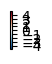

In [31]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

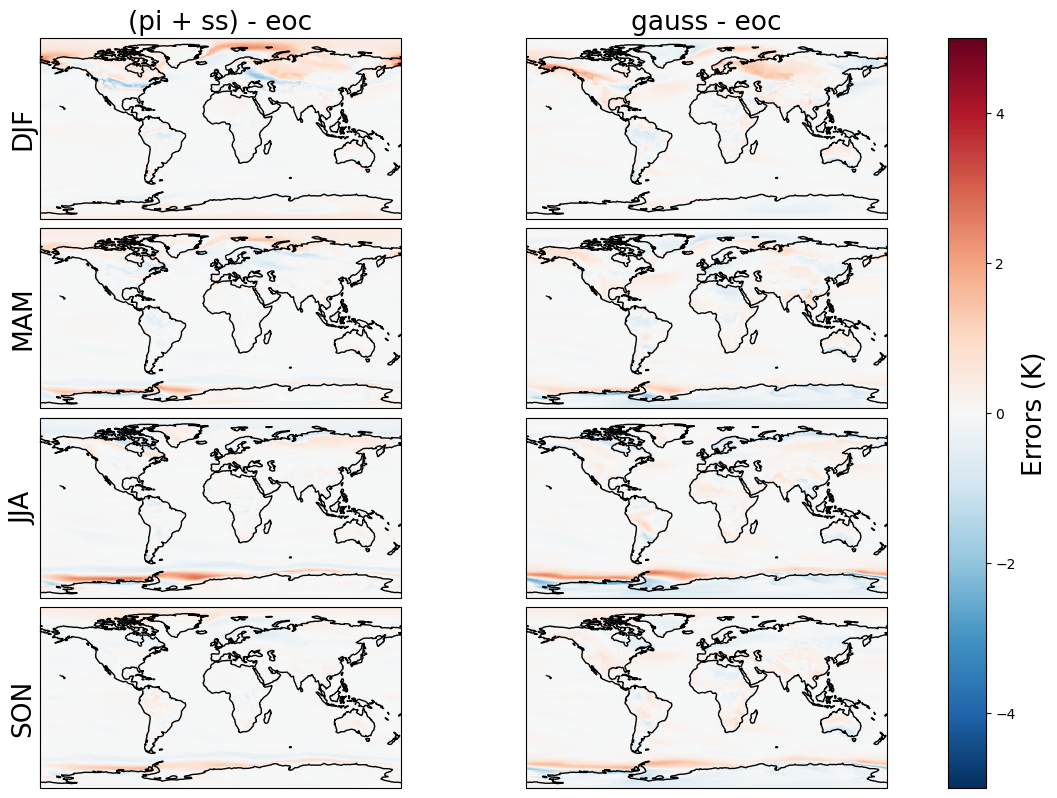

CPU times: user 7min 31s, sys: 30.3 s, total: 8min 1s
Wall time: 7min 43s


In [32]:
%%time
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(13.5,10), 
                        subplot_kw={'projection': cart.crs.PlateCarree()}) 
                        #gridspec_kw = {'wspace':0.02, 'hspace':0.01,'top':0.4,'bottom':0.1})

# # Reduce the padding around each subplot
#plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Adding titles for the rows
fig.text(0.12, 0.86, 'DJF', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.67, 'MAM', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.48, 'JJA', va='center', rotation='vertical',fontsize=19)
fig.text(0.12, 0.28, 'SON', va='center', rotation='vertical',fontsize=19)

# Plotting qgmsc_err1
im1= qgmsc_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 0].coastlines(color="black")
axs[0, 0].set_title('(pi + ss) - eoc',fontsize=19)
#
im2 = qgmsc_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 0].coastlines(color="black")
axs[1, 0].set_title('')
#
im3 = qgmsc_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 0].coastlines(color="black")
axs[2, 0].set_title('')
#
im4 = qgmsc_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 0], transform=cart.crs.PlateCarree(), 
                                        add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 0].coastlines(color="black")
axs[3, 0].set_title('')

##### DJF #################
# # Plotting qgauss_err1
im5 = qgauss_djf_err.sel(quantile=0.9).mean('day').plot(ax=axs[0, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[0, 1].coastlines(color="black")
axs[0, 1].set_title('gauss - eoc',fontsize=19)

######## Plotting MAM #######################
# Plotting qgauss_err1
im6 = qgauss_mam_err.sel(quantile=0.9).mean('day').plot(ax=axs[1, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[1, 1].coastlines(color="black")
axs[1, 1].set_title('')

######## Plotting JJA #######################

# Plotting qgauss_err1
im7 = qgauss_jja_err.sel(quantile=0.9).mean('day').plot(ax=axs[2, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[2, 1].coastlines(color="black")
axs[2, 1].set_title('')
######## Plotting SON #######################

# Plotting qgauss_err1
im8 = qgauss_son_err.sel(quantile=0.9).mean('day').plot(ax=axs[3, 1], transform=cart.crs.PlateCarree(), 
                                         add_colorbar=False, cmap=cmap, norm=norm)
axs[3, 1].coastlines(color="black")
axs[3, 1].set_title('')

# Creating a mappable object for the colorbar
mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.001, hspace=0.05)

# Adding colorbar
cbar = plt.colorbar(mappable, ax=axs.ravel().tolist(), shrink=1, orientation='vertical')
cbar.set_label('Errors (K)',fontsize=19)
#fig.tight_layout()
plt.show()

In [33]:
%%time
qgmsc_err = xr.concat([qgmsc_djf_err,qgmsc_mam_err,qgmsc_jja_err,qgmsc_son_err],dim='day')
qgmc_err  = xr.concat([qgmc_djf_err,qgmc_mam_err,qgmc_jja_err,qgmc_son_err],dim='day')
#qgmsc_err

CPU times: user 545 ms, sys: 102 ms, total: 647 ms
Wall time: 625 ms


In [34]:
%%time
qgauss_err = xr.concat([qgauss_djf_err,qgauss_mam_err,qgauss_jja_err,qgauss_son_err],dim='day')
qgeocm_err = xr.concat([qgeocm_djf_err,qgeocm_mam_err,qgeocm_jja_err,qgeocm_son_err],dim='day')
#qgauss_err

CPU times: user 535 ms, sys: 91.2 ms, total: 626 ms
Wall time: 600 ms


In [35]:
# Take a zonal average (weighted mean over longitude)

In [36]:
weights      = np.cos(np.deg2rad(qgmsc_err.lat))
weights.name = "weights"

In [37]:
%%time
qgmsc_err_weighted     = qgmsc_err.weighted(weights)
qgauss_err_weighted    = qgauss_err.weighted(weights)

CPU times: user 3.92 ms, sys: 4.88 ms, total: 8.8 ms
Wall time: 10.2 ms


In [38]:
qgmsc_err_zmean     = qgmsc_err_weighted.mean('lon')
qgauss_err_zmean    = qgauss_err_weighted.mean('lon')

In [39]:
##### Get masked arrays for land and ocean #############

In [40]:
%%time
landfrac        = landfrac.sel(time='21000101')
qgmsc_abserr    = (np.fabs(qgmsc_err) < 1.0)
qgauss_abserr   = (np.fabs(qgauss_err) < 1.0)
qgauss_abserr

CPU times: user 48.7 ms, sys: 5.06 ms, total: 53.8 ms
Wall time: 47.5 ms


,Array,Chunk
Bytes,1.90 GiB,295.90 kiB
Shape,"(101, 192, 288, 365)","(101, 20, 30, 5)"
Count,30004 Tasks,7500 Chunks
Type,bool,numpy.ndarray


In [41]:
%%time
M                     = 192*288*365
qgmsc_err_fracn1      = qgmsc_abserr.sum({'day','lat','lon'})/M
qgauss_err_fracn1     = qgauss_abserr.sum({'day','lat','lon'})/M
#### Land #######
qgmsc_land_errfracn1  = qgmsc_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
qgauss_land_errfracn1 = qgauss_abserr.where(landfrac==1).mean({'day','lat','lon'},skipna=True)
#### Ocean ######
qgmsc_ocean_errfracn1 = qgmsc_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)
qgauss_ocean_errfracn1= qgauss_abserr.where(landfrac==0).mean({'day','lat','lon'},skipna=True)

CPU times: user 3.6 s, sys: 152 ms, total: 3.75 s
Wall time: 3.63 s


In [42]:
#landfrac.values

In [43]:
# %%time
M                      = 192*288*365
# qgmw_diff_fracn0.5     = (np.fabs(qgmw_diff) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff1_fracn0.5 = (np.fabs(qgmw_reldiff1) < 0.5).sum({'day','lat','lon'})/M
# qgmw_reldiff2_fracn0.5 = (np.fabs(qgmw_reldiff2) < 0.5).sum({'day','lat','lon'})/M

In [44]:
# qgmsc_err_chk      = (np.fabs(qgmsc_err) < 1.0)
# qgmsc_land_err_chk = qgmsc_err_chk.where(landfrac==1).mean(['day','lat','lon'],skipna=True)
# qgmsc_land_err_chk.plot()

In [45]:
# qgmsc_land_err_chk2 = (np.fabs(qgmsc_land_err) < 1.0)
# qgmsc_land_err_chk2.sum('day').sel(quantile=0.5).plot()

In [46]:
quants = np.arange(0.0,1.01,0.01)

In [47]:
%%time
########### Save the fracn of errors <1K  ############
qgmsc_errfracn1path           = cvals+'qgmsc_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_errfracn1path          = cvals+'qgauss_err<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#### Land #######
qgmsc_land_errfracn1path   = cvals+'qgmsc_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_land_errfracn1path  = cvals+'qgauss_err_land<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##### Ocean #####
qgmsc_ocean_errfracn1path  = cvals+'qgmsc_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ocean_errfracn1path = cvals+'qgauss_err_ocean<1K'+'_'+ic_year0+'_'+ic_year1+'.zarr'
########################################
# qgmsc_land_errfracn1.to_dataset().to_zarr(qgmsc_land_errfracn1path,mode='w')
# qgauss_land_errfracn1.to_dataset().to_zarr(qgauss_land_errfracn1path,mode='w')
# #
# qgmsc_ocean_errfracn1.to_dataset().to_zarr(qgmsc_ocean_errfracn1path,mode='w')
# qgauss_ocean_errfracn1.to_dataset().to_zarr(qgauss_ocean_errfracn1path,mode='w')
# #
# qgmsc_err_fracn1.to_dataset().to_zarr(qgmsc_errfracn1path,mode='w')
# qgauss_err_fracn1.to_dataset().to_zarr(qgauss_errfracn1path,mode='w')

CPU times: user 41 µs, sys: 0 ns, total: 41 µs
Wall time: 58.4 µs


In [48]:
########### Open and PLot ############
qgmsc_land_errfracn1  = xr.open_zarr(qgmsc_land_errfracn1path)
qgauss_land_errfracn1 = xr.open_zarr(qgauss_land_errfracn1path)
qgmsc_land_errfracn1  = qgmsc_land_errfracn1.TREFHTMX
qgauss_land_errfracn1 = qgauss_land_errfracn1.TREFHTMX
##
qgmsc_ocean_errfracn1 = xr.open_zarr(qgmsc_ocean_errfracn1path)
qgauss_ocean_errfracn1= xr.open_zarr(qgauss_ocean_errfracn1path)
qgmsc_ocean_errfracn1 = qgmsc_ocean_errfracn1.TREFHTMX
qgauss_ocean_errfracn1= qgauss_ocean_errfracn1.TREFHTMX
#
qgmsc_errfracn1       = xr.open_zarr(qgmsc_errfracn1path)
qgauss_errfracn1      = xr.open_zarr(qgauss_errfracn1path)
qgmsc_errfracn1       = qgmsc_errfracn1.TREFHTMX
qgauss_errfracn1      = qgauss_errfracn1.TREFHTMX

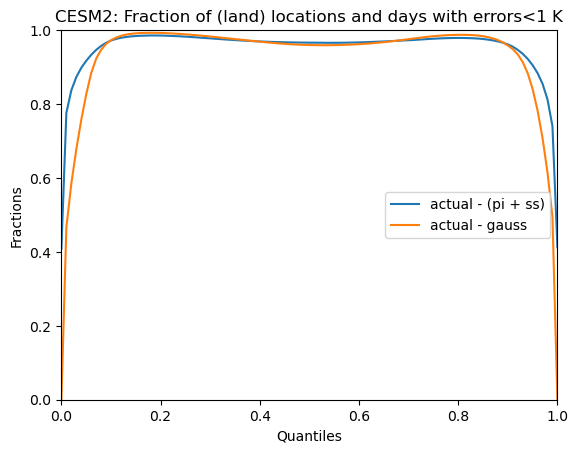

CPU times: user 1.94 s, sys: 183 ms, total: 2.12 s
Wall time: 2.05 s


In [49]:
%%time
quants = np.arange(0,1.01,0.01)
plt.plot(quants,qgmsc_land_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_land_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of (land) locations and days with errors<1 K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [50]:
#qgmw_reldiff2_fracn0.values

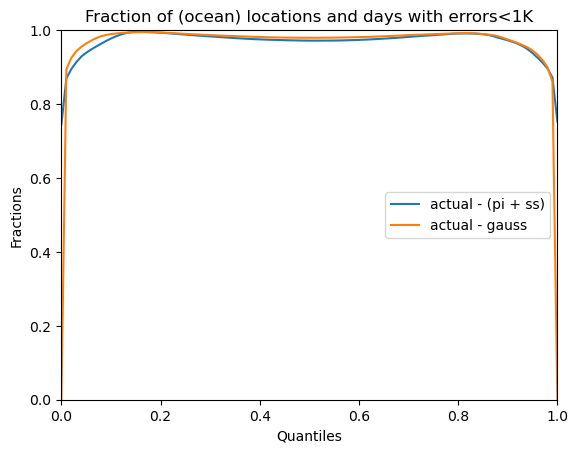

CPU times: user 1.97 s, sys: 163 ms, total: 2.14 s
Wall time: 2.05 s


In [51]:
%%time
plt.plot(quants,qgmsc_ocean_errfracn1,label='actual - (pi + ss)', c='tab:blue')
plt.plot(quants,qgauss_ocean_errfracn1,label='actual - gauss',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('Fraction of (ocean) locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

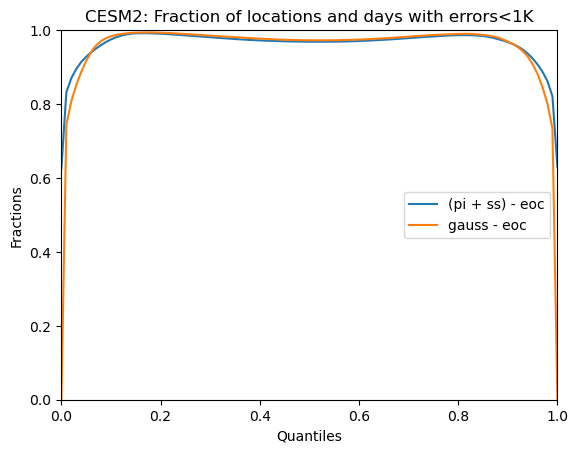

CPU times: user 1.89 s, sys: 154 ms, total: 2.04 s
Wall time: 1.93 s


In [52]:
%%time
plt.plot(quants,qgmsc_errfracn1,label='(pi + ss) - eoc', c='tab:blue')
plt.plot(quants,qgauss_errfracn1,label='gauss - eoc',c='tab:orange')
#plt.plot(quants,qgmw_reldiff2_fracn0,label='actual - (pi + shift+ stretch)',c='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Fraction of locations and days with errors<1K')
plt.ylabel('Fractions')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

In [53]:
############# Plot 4 ################

In [54]:
# %%time
# #Quantile q=0.1
# #Plot 4c
# levs     = np.arange(-4,4.4,0.4)
# ax       = plt.axes(projection=cart.crs.PlateCarree())
# qgmw_son_reldiff2.sel(quantile=0.9).mean('day')\
# .plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs,cmap=cmap_divergent)
# plt.plot(-87.629,41.94,marker='*')
# plt.plot(77.5,12.72,marker='*')
# ax.coastlines(color="black")
# #ax.gridlines()
# #plt.title('q=0.9,'+r'$\delta t_w - 0$')
# plt.title('q=0.9, actual - (pi + shift + stretch), SON mean')

In [55]:
############## Plot 5 #########################

In [56]:
############# Compute area-weighted mean square of the above errors #####################

In [57]:
# g = global, l=land, o=ocean
qgmsc_grmse   = global_annual_rmse(qgmsc_err,'day')
qgauss_grmse  = global_annual_rmse(qgauss_err,'day')
qgmc_grmse    = global_annual_rmse(qgmc_err,'day')
qgeocm_grmse  = global_annual_rmse(qgeocm_err,'day')
qgmsc_lrmse   = global_annual_rmse(qgmsc_err.where(landfrac==1),'day')
qgauss_lrmse  = global_annual_rmse(qgauss_err.where(landfrac==1),'day')
qgmsc_ormse   = global_annual_rmse(qgmsc_err.where(landfrac==0),'day')
qgauss_ormse  = global_annual_rmse(qgauss_err.where(landfrac==0),'day')

In [58]:
qgmsc_lrmse

<xarray.DataArray 'TREFHTMX' (quantile: 101, time: 1)>
dask.array<sqrt, shape=(101, 1), dtype=float64, chunksize=(101, 1), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086
  * time      (time) object 2100-01-01 00:00:00

In [59]:
%%time
# qgmw_grmsepath   = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_grmsepath   = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_grmsepath  = cvals+'qgmsc_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_grmsepath = cvals+'qgauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_grmsepath = cvals+'qgeocm_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_lrmsepath  = cvals+'qgmsc_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_lrmsepath = cvals+'qgauss_land_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#
qgmsc_ormsepath  = cvals+'qgmsc_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_ormsepath = cvals+'qgauss_ocean_rmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_grmse.to_dataset().to_zarr(qgmw_grmsepath,mode='w')
# qgmc_grmse.to_dataset().to_zarr(qgmc_grmsepath,mode='w')
# qgmsc_grmse.to_dataset().to_zarr(qgmsc_grmsepath,mode='w')
# qgauss_grmse.to_dataset().to_zarr(qgauss_grmsepath,mode='w')
# qgeocm_grmse.to_dataset().to_zarr(qgeocm_grmsepath,mode='w')
# #
# qgmsc_lrmse.to_dataset().to_zarr(qgmsc_lrmsepath,mode='w')
# qgauss_lrmse.to_dataset().to_zarr(qgauss_lrmsepath,mode='w')
# #
# qgmsc_ormse.to_dataset().to_zarr(qgmsc_ormsepath,mode='w')
# qgauss_ormse.to_dataset().to_zarr(qgauss_ormsepath,mode='w')

CPU times: user 0 ns, sys: 61 µs, total: 61 µs
Wall time: 88 µs


In [60]:
%%time
# qgmw_grmse   = xr.open_zarr(qgmw_grmsepath)
qgmc_grmse   = xr.open_zarr(qgmc_grmsepath)
# qgmw_grmse   = qgmw_grmse.TREFHTMX
qgmc_grmse   = qgmc_grmse.TREFHTMX
qgmsc_grmse  = xr.open_zarr(qgmsc_grmsepath)
qgauss_grmse = xr.open_zarr(qgauss_grmsepath)
qgeocm_grmse = xr.open_zarr(qgeocm_grmsepath)
qgmsc_lrmse  = xr.open_zarr(qgmsc_lrmsepath)
qgauss_lrmse = xr.open_zarr(qgauss_lrmsepath)
qgmsc_ormse  = xr.open_zarr(qgmsc_ormsepath)
qgauss_ormse = xr.open_zarr(qgauss_ormsepath)
#
qgmsc_grmse  = qgmsc_grmse.TREFHTMX
qgauss_grmse = qgauss_grmse.TREFHTMX
qgeocm_grmse = qgeocm_grmse.TREFHTMX
#
qgmsc_lrmse  = qgmsc_lrmse.TREFHTMX
qgauss_lrmse = qgauss_lrmse.TREFHTMX
#
qgmsc_ormse  = qgmsc_ormse.TREFHTMX
qgauss_ormse = qgauss_ormse.TREFHTMX
#

CPU times: user 721 ms, sys: 112 ms, total: 833 ms
Wall time: 779 ms


In [61]:
qgauss_grmse.loc[dict(quantile=0)]=1e10
qgauss_grmse.loc[dict(quantile=1)]=1e10
qgauss_grmse.values

array([1.00000000e+10, 9.18280770e-01, 7.14377717e-01, 5.94298866e-01,
       5.09399258e-01, 4.44434120e-01, 3.92504955e-01, 3.49938233e-01,
       3.14555678e-01, 2.85054434e-01, 2.60563571e-01, 2.40419769e-01,
       2.24187531e-01, 2.11483475e-01, 2.01956124e-01, 1.95300971e-01,
       1.91164838e-01, 1.89172517e-01, 1.89034215e-01, 1.90410698e-01,
       1.92999998e-01, 1.96523215e-01, 2.00757540e-01, 2.05508657e-01,
       2.10615225e-01, 2.15938911e-01, 2.21370611e-01, 2.26840446e-01,
       2.32284565e-01, 2.37635644e-01, 2.42862793e-01, 2.47928713e-01,
       2.52811471e-01, 2.57484126e-01, 2.61935980e-01, 2.66160475e-01,
       2.70138615e-01, 2.73866414e-01, 2.77334988e-01, 2.80544290e-01,
       2.83498995e-01, 2.86186978e-01, 2.88594648e-01, 2.90741993e-01,
       2.92616277e-01, 2.94213542e-01, 2.95526976e-01, 2.96582074e-01,
       2.97352692e-01, 2.97845843e-01, 2.98069280e-01, 2.98016455e-01,
       2.97690600e-01, 2.97085398e-01, 2.96200722e-01, 2.95036324e-01,
      

In [62]:
qgeocm_grmse.loc[dict(quantile=0)]=1e10
qgeocm_grmse.loc[dict(quantile=1)]=1e10
qgeocm_grmse.values

array([1.00000000e+10, 1.70464832e+00, 1.49045443e+00, 1.36380542e+00,
       1.27323096e+00, 1.20242401e+00, 1.14417042e+00, 1.09452314e+00,
       1.05112646e+00, 1.01246369e+00, 9.77497471e-01, 9.45495276e-01,
       9.15909219e-01, 8.88286110e-01, 8.62333326e-01, 8.37778214e-01,
       8.14423675e-01, 7.92112060e-01, 7.70699424e-01, 7.50091000e-01,
       7.30162968e-01, 7.10849883e-01, 6.92085705e-01, 6.73803283e-01,
       6.55955856e-01, 6.38506982e-01, 6.21412941e-01, 6.04641969e-01,
       5.88184743e-01, 5.72000163e-01, 5.56077602e-01, 5.40397587e-01,
       5.24956872e-01, 5.09737822e-01, 4.94743539e-01, 4.79974728e-01,
       4.65432156e-01, 4.51123286e-01, 4.37055885e-01, 4.23242563e-01,
       4.09713760e-01, 3.96485207e-01, 3.83575931e-01, 3.71038798e-01,
       3.58906773e-01, 3.47227513e-01, 3.36057307e-01, 3.25486456e-01,
       3.15566726e-01, 3.06392859e-01, 2.98069280e-01, 2.90694012e-01,
       2.84380945e-01, 2.79238377e-01, 2.75378231e-01, 2.72910412e-01,
      

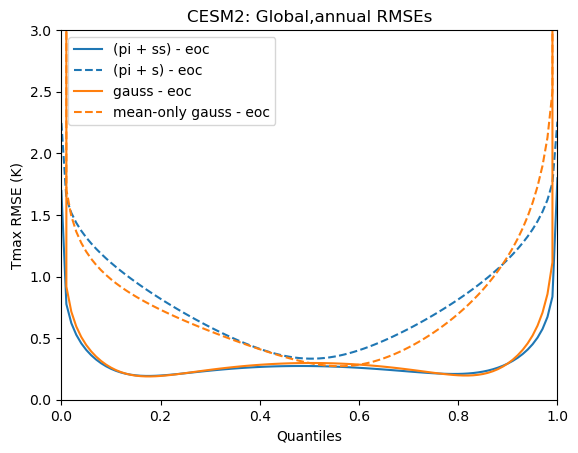

CPU times: user 2.4 s, sys: 195 ms, total: 2.59 s
Wall time: 2.62 s


In [63]:
%%time
plt.plot(quants,qgmsc_grmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgmc_grmse,'--',label = '(pi + s) - eoc',color='tab:blue')
plt.plot(quants,qgauss_grmse,label='gauss - eoc',color='tab:orange')
plt.plot(quants,qgeocm_grmse,'--',label = 'mean-only gauss - eoc',color='tab:orange')
plt.legend(loc='upper left')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

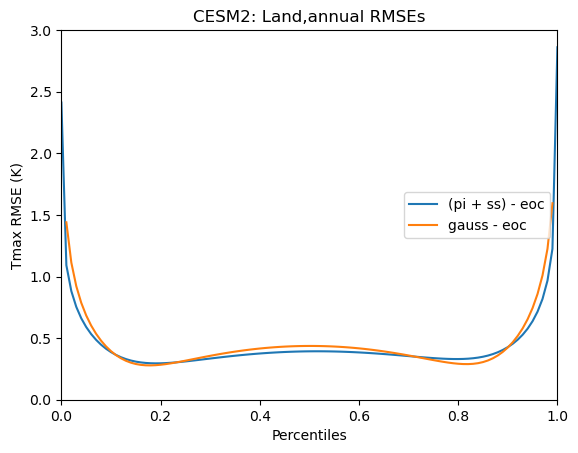

CPU times: user 1.92 s, sys: 143 ms, total: 2.07 s
Wall time: 2.1 s


In [58]:
%%time
plt.plot(quants,qgmsc_lrmse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_lrmse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Land,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

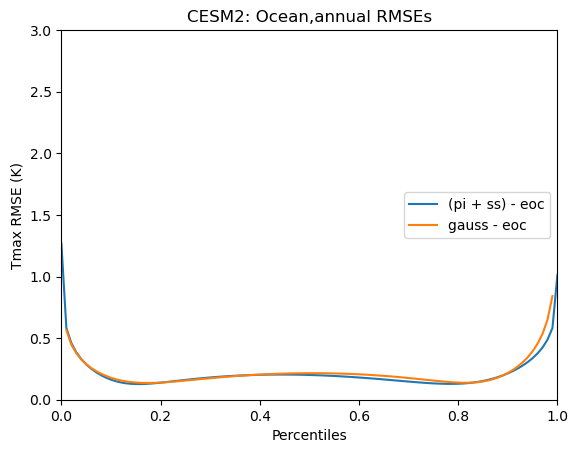

CPU times: user 1.88 s, sys: 161 ms, total: 2.04 s
Wall time: 2.04 s


In [59]:
%%time
plt.plot(quants,qgmsc_ormse,label='(pi + ss) - eoc',color='tab:blue')
plt.plot(quants,qgauss_ormse,label='gauss - eoc',color='tab:orange')
plt.legend(loc='center right')
plt.title('CESM2: Ocean,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,3.0)
plt.show()

In [60]:
#qgmsc_lrmse.values

In [61]:
#qgauss_lrmse.values

In [62]:
#qgmsc_ormse.values

In [63]:
#qgauss_ormse.values

CPU times: user 1.5 s, sys: 126 ms, total: 1.63 s
Wall time: 2.1 s


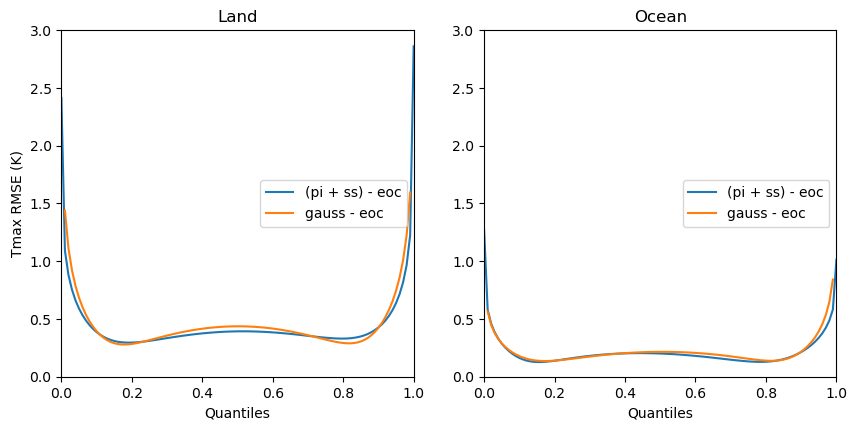

In [64]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

qgmsc_lrmse.plot(ax=axs[0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0],label='gauss - eoc')
axs[0].set_title('Land')
axs[0].set_xlabel('Quantiles')
axs[0].set_ylabel('Tmax RMSE (K)')
axs[0].set_xlim(0.0,1.0)
axs[0].set_ylim(0.0,3.0)
axs[0].legend(loc='center right')
#
im = qgmsc_ormse.plot(ax=axs[1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[1],label='gauss - eoc')
axs[1].set_title('Ocean')
axs[1].set_xlabel('Quantiles')
axs[1].set_ylabel('')
axs[1].set_xlim(0.0,1.0)
axs[1].set_ylim(0.0,3.0)
axs[1].legend(loc='center right')
# plot.show()

In [64]:
qgauss_lrmse.loc[dict(quantile=0)]=1e10
qgauss_lrmse.loc[dict(quantile=1)]=1e10
qgauss_ormse.loc[dict(quantile=0)]=1e10
qgauss_ormse.loc[dict(quantile=1)]=1e10

CPU times: user 4.24 s, sys: 307 ms, total: 4.54 s
Wall time: 5.43 s


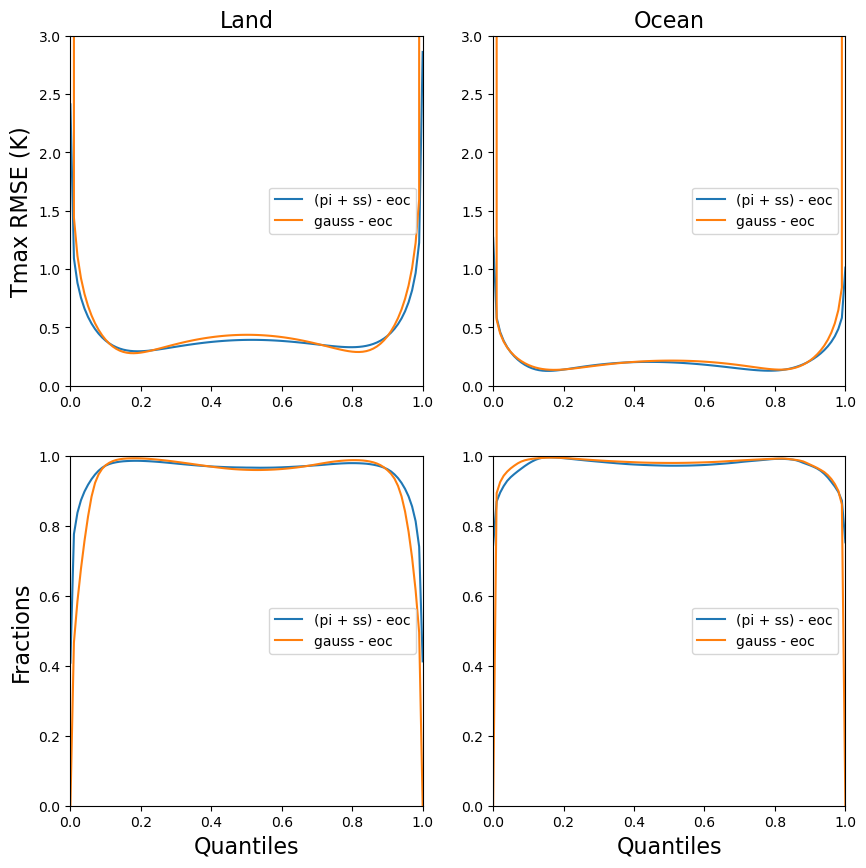

In [65]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10),gridspec_kw = {'wspace':0.2, 'hspace':0.2})

im1 = qgmsc_lrmse.plot(ax=axs[0,0],label='(pi + ss) - eoc')
qgauss_lrmse.plot(ax=axs[0,0],label='gauss - eoc')
axs[0,0].set_title('Land',fontsize=16)
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Tmax RMSE (K)',fontsize=16)
axs[0,0].set_xlim(0.0,1.0)
axs[0,0].set_ylim(0.0,3.0)
axs[0,0].legend(loc='center right')
#
im2 = qgmsc_ormse.plot(ax=axs[0,1],label='(pi + ss) - eoc')
qgauss_ormse.plot(ax=axs[0,1],label='gauss - eoc')
axs[0,1].set_title('Ocean',fontsize=16)
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('')
axs[0,1].set_xlim(0.0,1.0)
axs[0,1].set_ylim(0.0,3.0)
axs[0,1].legend(loc='center right')
#
im3 = qgmsc_land_errfracn1.plot(ax=axs[1,0],label='(pi + ss) - eoc')
qgauss_land_errfracn1.plot(ax=axs[1,0],label='gauss - eoc')
axs[1,0].set_title('')
axs[1,0].set_xlabel('Quantiles',fontsize=16)
axs[1,0].set_ylabel('Fractions',fontsize=16)
axs[1,0].set_xlim(0.0,1.0)
axs[1,0].set_ylim(0.0,1.0)
axs[1,0].legend(loc='center right')
#
im4 = qgmsc_ocean_errfracn1.plot(ax=axs[1,1],label='(pi + ss) - eoc')
qgauss_ocean_errfracn1.plot(ax=axs[1,1],label='gauss - eoc')
axs[1,1].set_title('')
axs[1,1].set_xlabel('Quantiles',fontsize=16)
axs[1,1].set_ylabel('')
axs[1,1].set_xlim(0.0,1.0)
axs[1,1].set_ylim(0.0,1.0)
axs[1,1].legend(loc='center right')
# plot.show()

In [66]:
%%time
error_redn = qgmsc_grmse.integrate('quantile')/qgmc_grmse.integrate('quantile')
error_redn.values

CPU times: user 123 ms, sys: 18.3 ms, total: 141 ms
Wall time: 487 ms


array(0.3786023)

In [67]:
########## Check CLT ###########

In [68]:
%%time
tgmw_d  = to_daily(tgmw)
tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
tgmw_d1 = tgmw_d.sel(year=slice(ic_year0,ic_year1))
tgmw_d1 = tgmw_d1.chunk({'day':30})
tgmw_d1

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


CPU times: user 604 ms, sys: 14 ms, total: 618 ms
Wall time: 608 ms


,Array,Chunk
Bytes,225.56 GiB,20.60 MiB
Shape,"(192, 288, 100, 30, 365)","(20, 30, 100, 3, 30)"
Count,104902 Tasks,16900 Chunks
Type,float32,numpy.ndarray


In [69]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
tgmw_eocroll       = stack_roll(tgmw_d1,N_mem*window_len,N_mem)
tgmw_piroll        = stack_roll(tgmw_d0,N_mem*window_len,N_mem)
#########
tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
tgmw_piroll0

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 3000)>
dask.array<reshape, shape=(192, 288, 365, 3000), dtype=float32, chunksize=(20, 30, 30, 300), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 2071 2071 2071 2071 2071 ... 2100 2100 2100 2100 2100
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 3000)>
dask.array<reshape, shape=(192, 288, 365, 3000), dtype=float32, chunksize=(20, 30, 365, 300), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 365, 1, 3000), dtype=float32, chunksize=(20, 30, 365, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 1865
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
Dimensions without coordinates: ym, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [70]:
tgmw_eocmroll = tgmw_eocroll0.mean('index')
tgmw_eocsroll = tgmw_eocroll0.std('index')
qgmw_eocroll  = tgmw_eocroll0.quantile(quants,dim='index',skipna=False)
######################

In [71]:
# Generate normal distributions using means and standard deviations
index = np.arange(3000) 

gaussians_eoc = xr.apply_ufunc(
    np.random.normal,
    tgmw_eocmroll,
    tgmw_eocsroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)

/tmp/ipykernel_69346/8299844.py:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gaussians_eoc = xr.apply_ufunc(


In [72]:
qgauss_eoc = gaussians_eoc.quantile(quants,dim='index',skipna=False)

In [73]:
qgmw_gauss_diff   = qgauss_eoc - qgmw_eocroll

In [74]:
### ###Save ######
qgmw_gauss_diffpath      = cvals+'qgmw_gauss_diff'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#qgmw_gauss_diff.to_dataset().to_zarr(qgmw_gauss_diffpath,mode='w')

In [75]:
# qgmw_gauss_diff   = xr.open_zarr(qgmw_gauss_diff)
# qgmw_gauss_diff   = qgmw_gauss_diff.TREFHTMX

In [76]:
qgmw_gesq                   = qgmw_gauss_diff**2
qgmw_gauss_serror_weighted  = qgmw_gesq.weighted(weights)
qgmw_gauss_serror_gmean     = qgmw_gauss_serror_weighted.mean({'lat','lon'})
################################################

ValueError: dimension 'ym' already exists as a scalar variable

In [ ]:
qgmw_gauss_gmse            = qgmw_gauss_serror_gmean.mean('day')
qgmw_gauss_grmse           = np.sqrt(qgmw_gauss_gmse)
qgmw_gauss_grmse 

In [ ]:
%%time
qgmw_gauss_grmsepath = cvals+'qgmw_gauss_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
##########################
#qgmw_gauss_grmse.to_dataset().to_zarr(qgmw_gauss_grmsepath,mode='w')

In [ ]:
qgmw_gauss_grmse = xr.open_zarr(qgmw_gauss_grmsepath)
qgmw_gauss_grmse = qgmw_gauss_grmse.TREFHTMX

In [ ]:
%%time
plt.plot(quants,qgmw_grmse,label='eoc - pi',color='tab:blue')
plt.plot(quants,qgmw_gauss_grmse,label='eoc - gaussian',color='red')
plt.plot(quants,qgmc_grmse,label='eoc - (pi + shift)',color='tab:orange')
plt.plot(quants,qgmsc_grmse,label='eoc - (pi + shift + stretch)',color='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()